In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [65]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [66]:
df.head(15)

,Product Name,Product Category,Sales,Market Size,Marketing Expense
Month-Year,,,,,
2019-01-01,Product A,Pain/Analgesic,54555,2738080,177316
2019-02-01,Product A,Pain/Analgesic,54293,4637013,300290
2019-03-01,Product A,Pain/Analgesic,58798,7079920,458491
2019-04-01,Product A,Pain/Analgesic,53229,3744057,242463
2019-05-01,Product A,Pain/Analgesic,50558,4196578,271768
2019-06-01,Product A,Pain/Analgesic,56326,6396559,414237
2019-07-01,Product A,Pain/Analgesic,50125,2545212,164826
2019-08-01,Product A,Pain/Analgesic,56414,6294066,407600
2019-09-01,Product A,Pain/Analgesic,55658,5454980,353261


In [67]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [68]:
sales_a.shape

(60, 3)

In [69]:
sales_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Sales              60 non-null     int64
 1   Market Size        60 non-null     int64
 2   Marketing Expense  60 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB


In [70]:
print('Total Sales:', sales_a['Sales'].sum())
print('Total Market Size:',sales_a['Market Size'].sum())
print('Total Marketing Expense:', sales_a['Marketing Expense'].sum())

Total Sales: 3213992
Total Market Size: 360874201
Total Marketing Expense: 19873176


Text(0.5, 1.0, 'Product A')

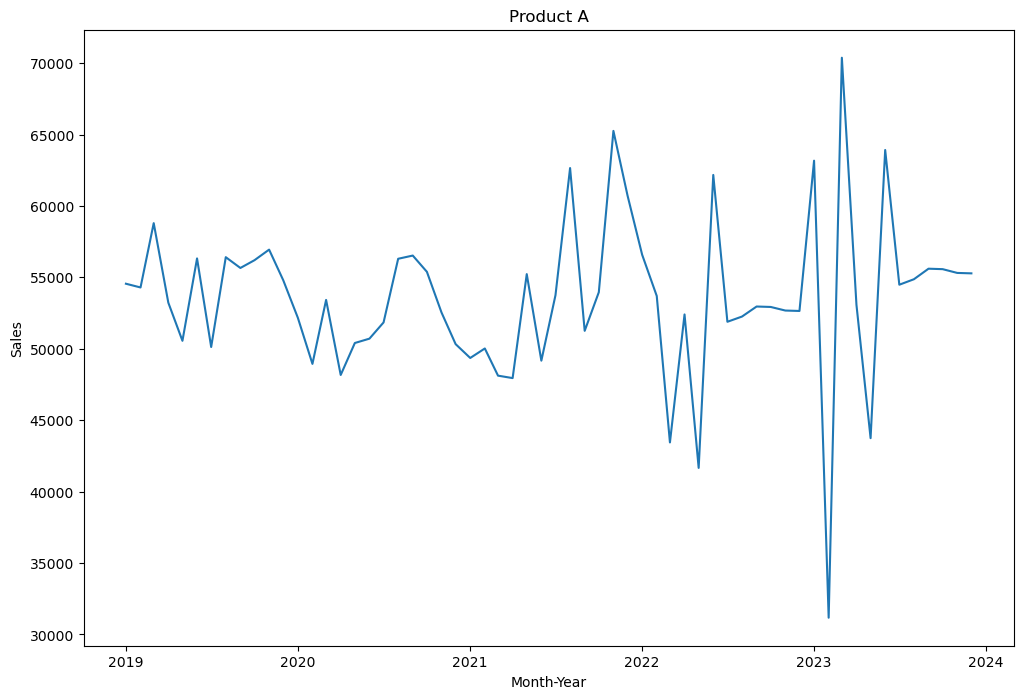

In [71]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_a['Sales'])
plt.title('Product A')

In [72]:
from statsmodels.tsa.stattools import adfuller

In [73]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [74]:
adf_test(sales_a['Sales'])

ADF Statistics: -10.095004165158468
p- value: 1.0967344875767964e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


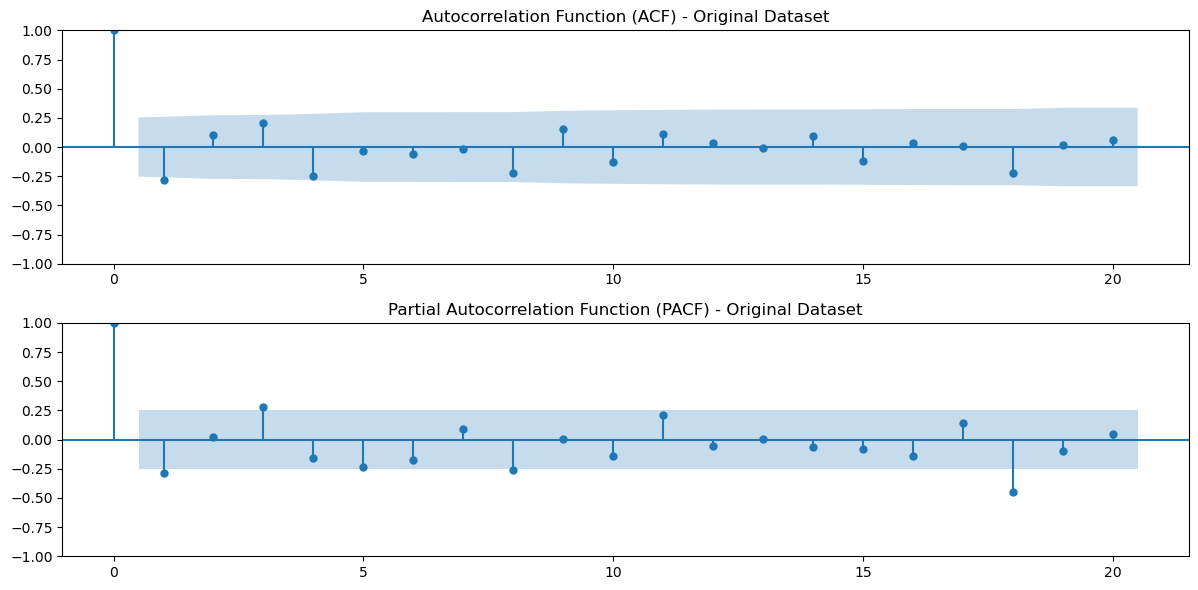

In [75]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_a['Sales'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Dataset')

plt.subplot(212)
plot_pacf(sales_a['Sales'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Dataset')

plt.tight_layout()
plt.show()

In [76]:
train= sales_a[:48]
test=sales_a[48:]

In [77]:
print(len(train),len(test))

48 12


In [78]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(2):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,0,q), exog=train[['Market Size','Marketing Expense']])
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_a)-1), exog=test[['Market Size','Marketing Expense']])
        mae = mean_absolute_error(test['Sales'], pred)
        mape = np.mean(np.abs((test['Sales'] - pred) / test)) * 100
        mse=mean_squared_error(test['Sales'], pred)
        rmse = np.sqrt(mean_squared_error(test['Sales'], pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [79]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic          mae           mse          rmse
8   4  0   942.396324   957.365932  8163.897106  1.276950e+08  11300.223140
2   1  0   944.018866   953.374871  7816.708762  1.188783e+08  10903.131084
10  5  0   944.426793   961.267602  8350.219823  1.314832e+08  11466.612098
9   4  1   944.478300   961.319109  8187.200018  1.280303e+08  11315.047284
1   0  1   944.522950   953.878955  7787.853501  1.185056e+08  10886.027280
4   2  0   944.704140   955.931346  8071.177397  1.225325e+08  11069.439307
3   1  1   945.766569   956.993775  7841.295551  1.188647e+08  10902.510105
11  5  1   946.485033   965.197043  8246.976991  1.292737e+08  11369.860766
6   3  0   946.679027   959.777434  7953.614532  1.207174e+08  10987.147581
5   2  1   946.960586   960.058993  8012.838343  1.216968e+08  11031.629441
7   3  1   948.811803   963.781411  7951.469554  1.206658e+08  10984.798011
0   0  0  1082.228211  1089.713015  7619.289161  1.157908e+08  10760.614026


In [80]:
m_arima= ARIMA(train['Sales'], order=(4,0,0), exog=train[['Market Size','Marketing Expense']])
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -463.198
Date:                Tue, 14 May 2024   AIC                            942.396
Time:                        20:07:39   BIC                            957.366
Sample:                    01-01-2019   HQIC                           948.053
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.059e+04   4.94e-06   1.02e+10      0.000    5.06e+04    5.06e+04
Market Size          -0.0003      0.001     -0.362      0.717      -0.002       0.001
Marketing Expense     0.

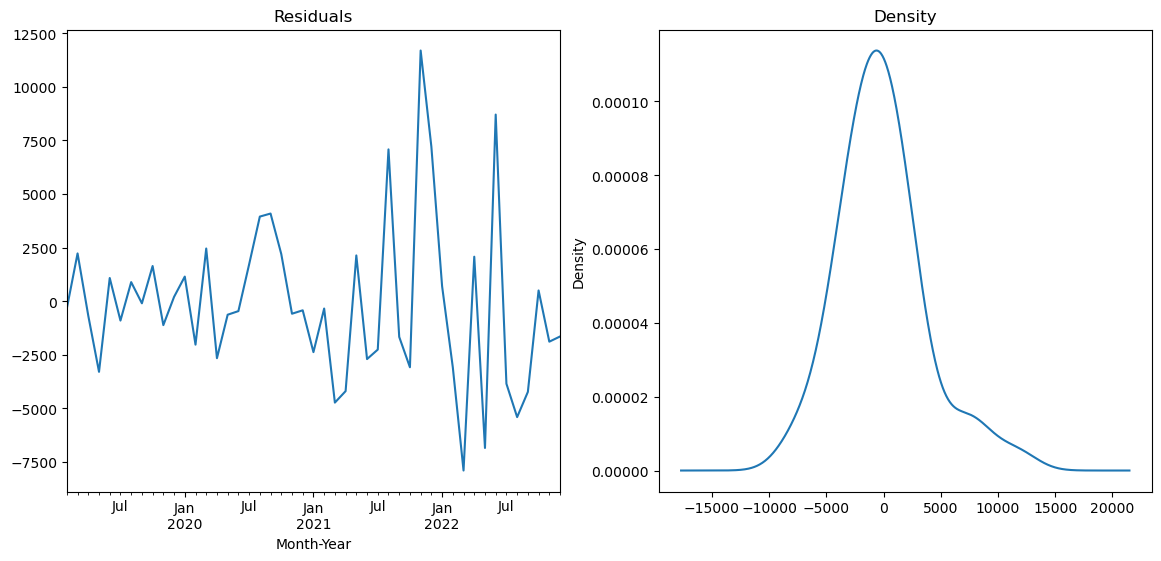

In [81]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

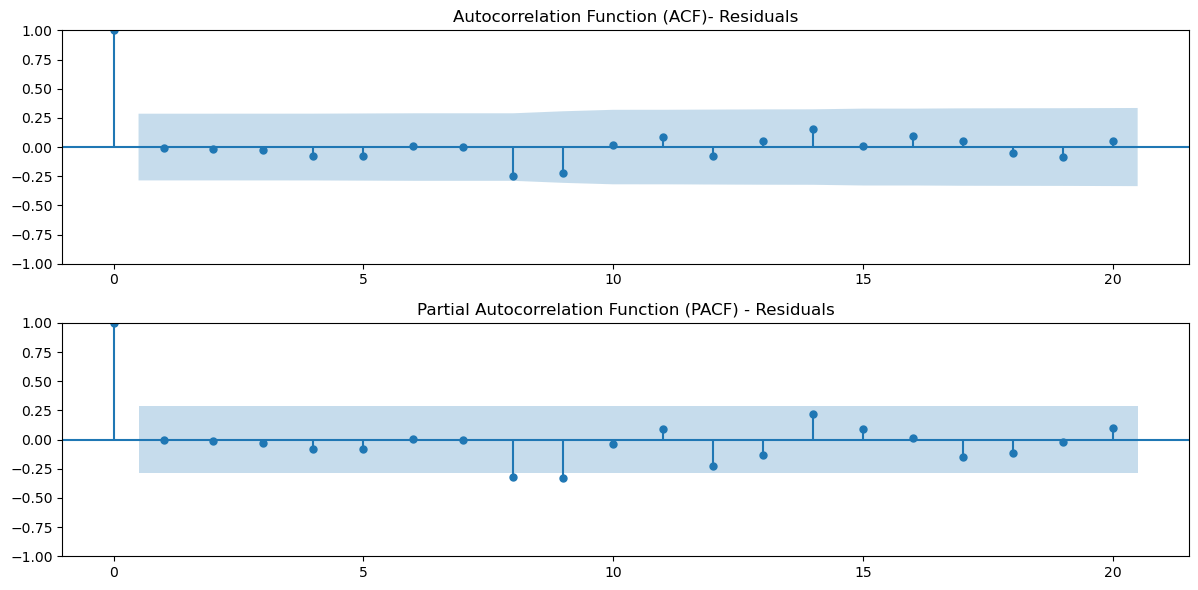

In [82]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

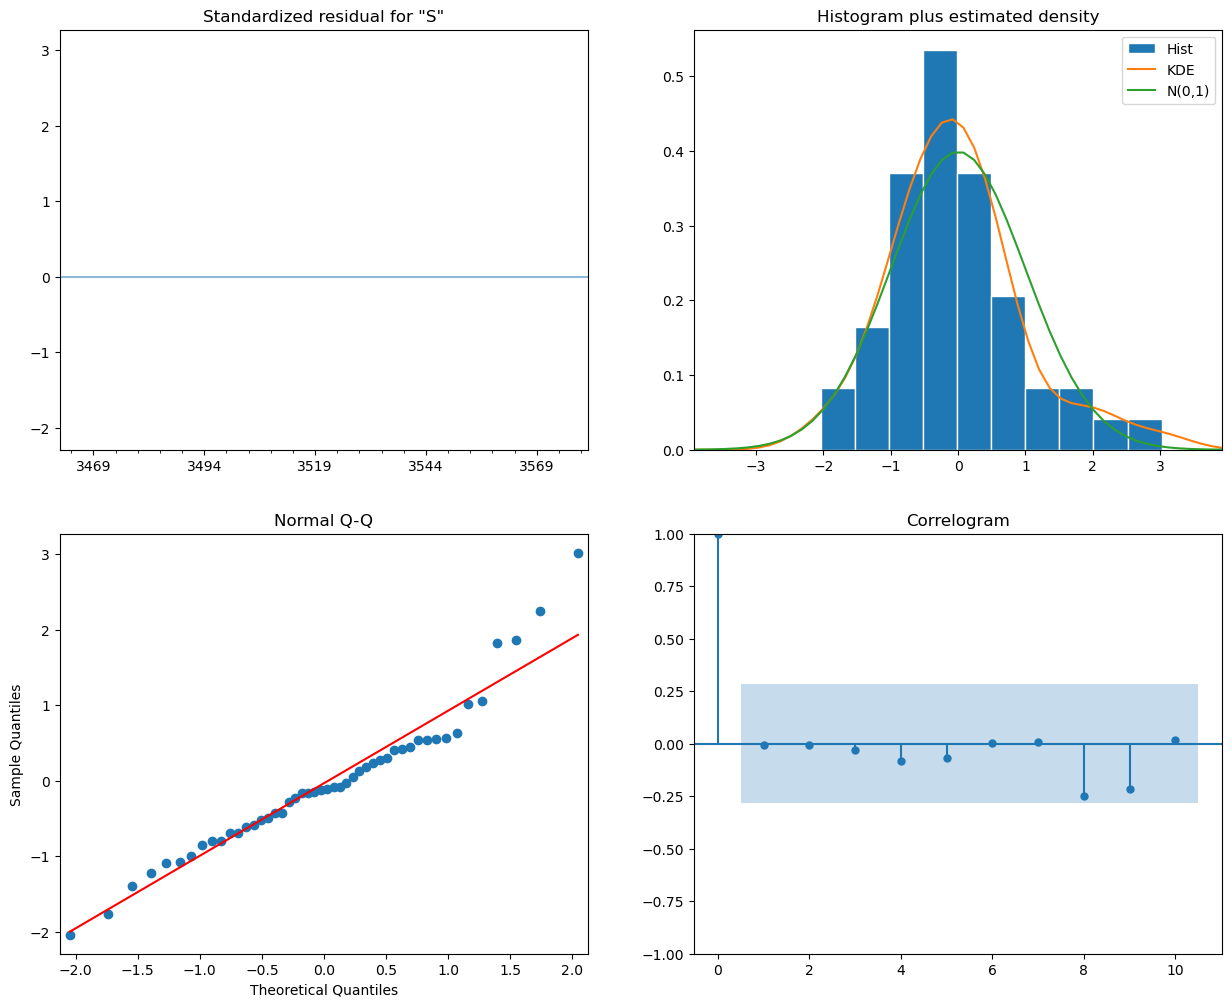

In [83]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [84]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [85]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [86]:
pred=model_arima.predict(start=len(train), end=(len(sales_a)-1), exog=test[['Market Size','Marketing Expense']], dynamic = True)
sales_a['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

In [87]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

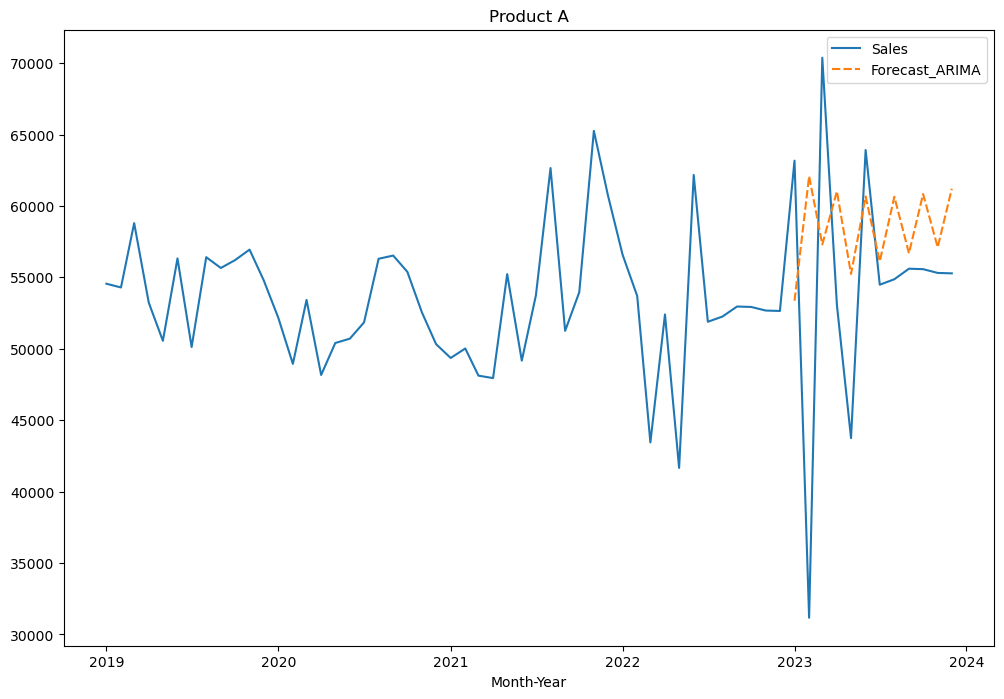

In [88]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_ARIMA']])
plt.title('Product A')
plt.show()

In [89]:
mae_arima= mean_absolute_error(test['Sales'],pred)
mse_arima=mean_squared_error(test['Sales'], pred)
mape_arima= mean_absolute_percentage_error(test['Sales'],pred)
rmse_arima= np.sqrt(mean_squared_error(test['Sales'],pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 8163.897106361961
MAPE - ARIMA: 0.18212035723435852
MSE - ARIMA: 127695043.00992523
RMSE - ARIMA: 11300.223139828931


# SARIMA

In [90]:
import statsmodels.api as sm

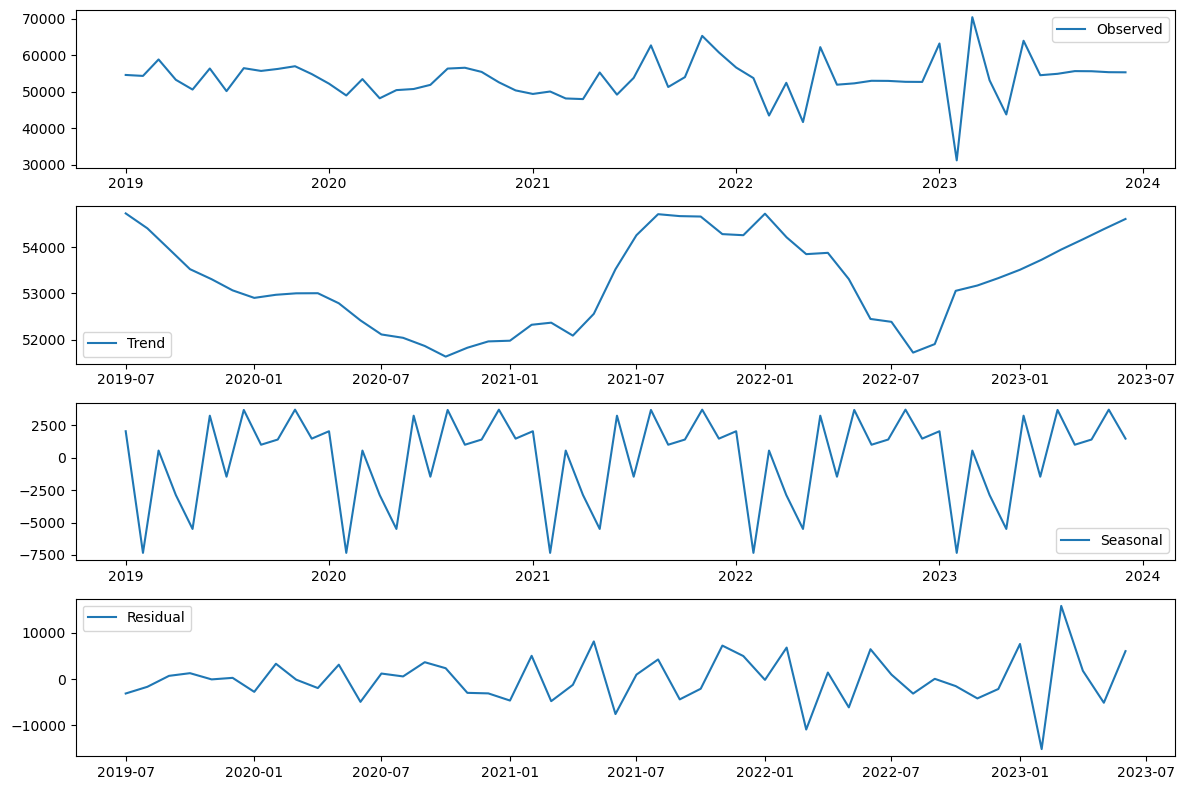

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_a['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

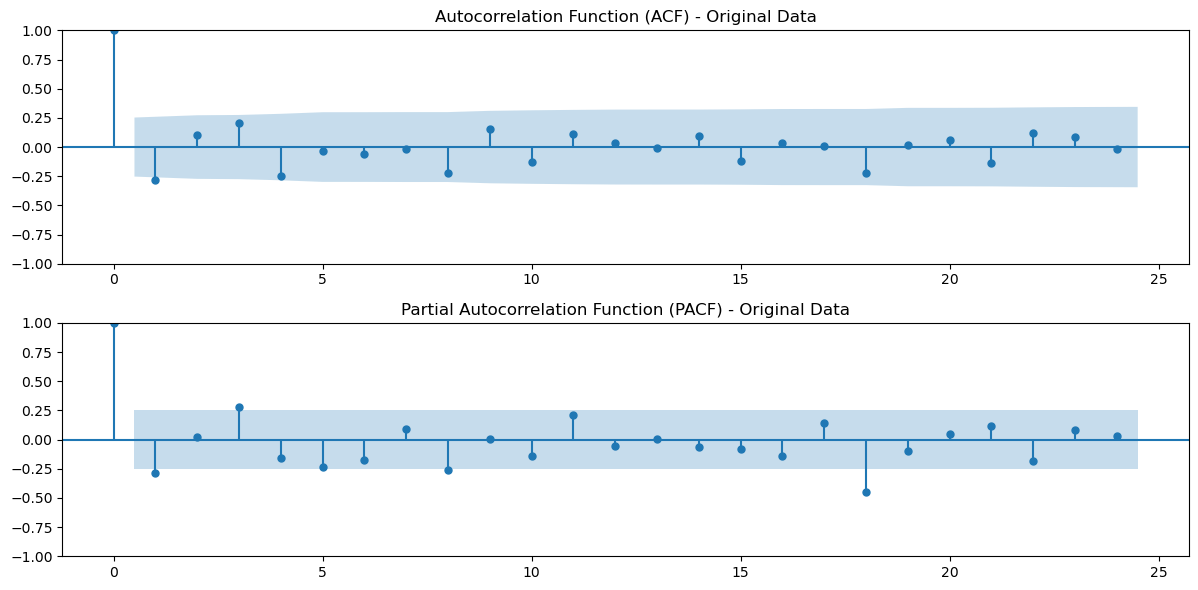

In [92]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_a['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_a['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [93]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 0, 0), seasonal_order=(P, 0, Q, 12),exog=train[['Market Size','Marketing Expense']])
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True, exog=test[['Market Size','Marketing Expense']])
        mae = mean_absolute_error(test['Sales'], pred)
        mse = mean_squared_error(test['Sales'], pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])


In [94]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic           mae           mse
0   0  0  1019.407964  1032.506371   7941.182922  1.289170e+08
2   1  0  1021.443652  1036.413260   8160.277927  1.308365e+08
1   0  1  1021.461610  1036.431218   8408.974281  1.332377e+08
3   1  1  1023.430810  1040.271619   8626.074972  1.347184e+08
4   2  0  1024.343732  1041.184541   8641.794895  1.440679e+08
5   2  1  1025.489344  1044.201355   7961.300801  1.261202e+08
6   3  0  1026.685030  1045.397040   9305.438174  1.580428e+08
7   3  1  1028.685273  1049.268484   8736.136012  1.469968e+08
8   4  0  1029.812384  1050.395595  11378.116204  1.951433e+08
9   4  1  1030.905039  1053.359451   8948.804353  1.544083e+08
10  5  0  1031.091729  1053.546141   9566.471000  1.633978e+08
11  5  1  1032.931902  1057.257515   8927.468074  1.525141e+08


In [95]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 0, 0),seasonal_order=(0,0,0,12),exog=train[['Market Size','Marketing Expense']])
sarima_model=sarima.fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -502.704
Date:                Tue, 14 May 2024   AIC                           1019.408
Time:                        20:09:44   BIC                           1032.506
Sample:                    01-01-2019   HQIC                          1024.358
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Market Size           0.0001      0.011      0.012      0.990      -0.021       0.022
Marketing Expense     0.0181      0.217      0.083      0.934      -0.406       0.442
ar.L1                 0.

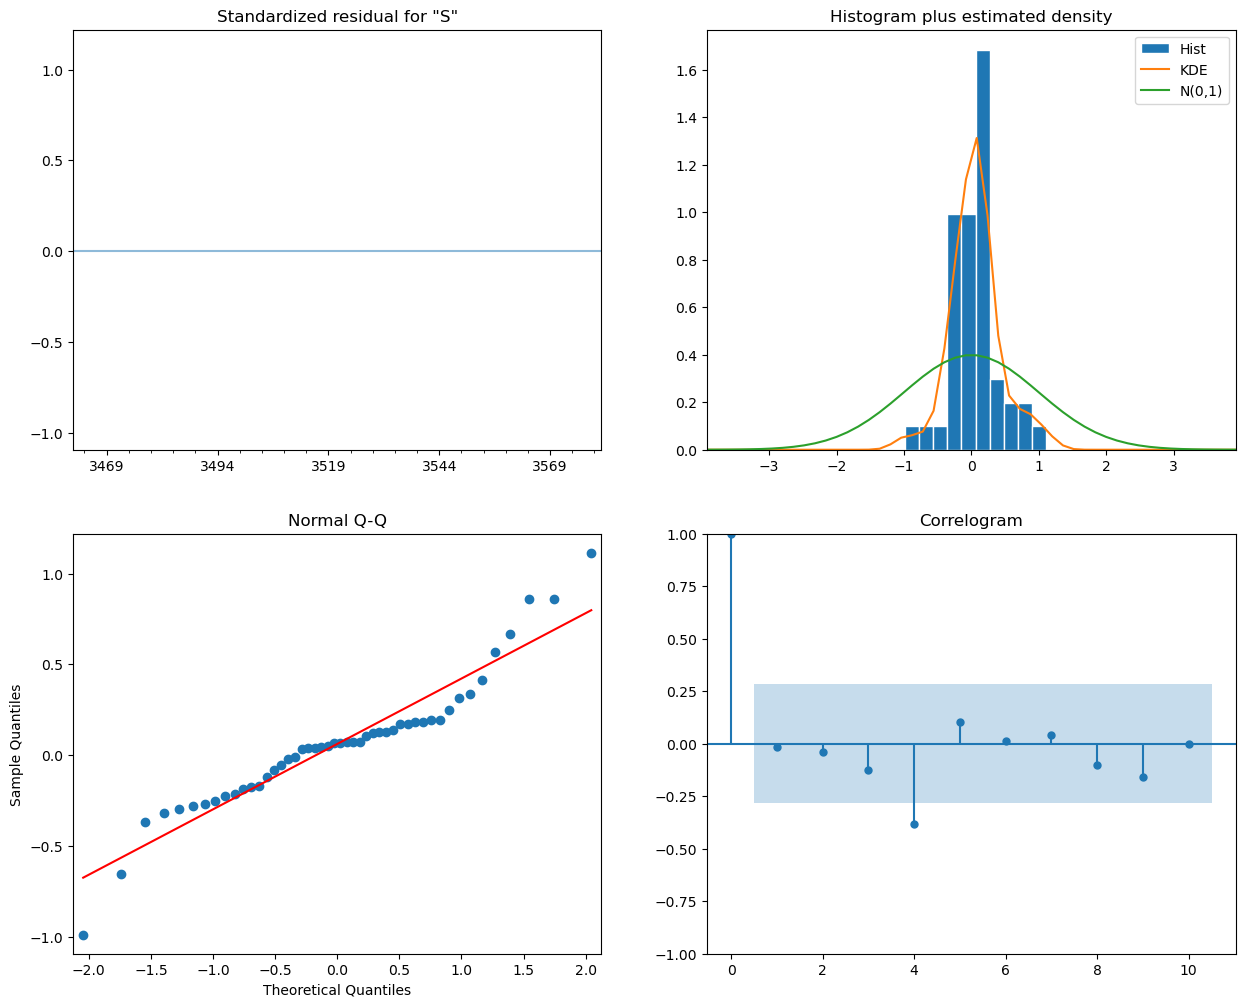

In [96]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [97]:
forecast_test_sarima=sarima_model.predict(start=48, end=59, dynamic=True, exog=test[['Market Size','Marketing Expense']])

In [98]:
sales_a['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product A')

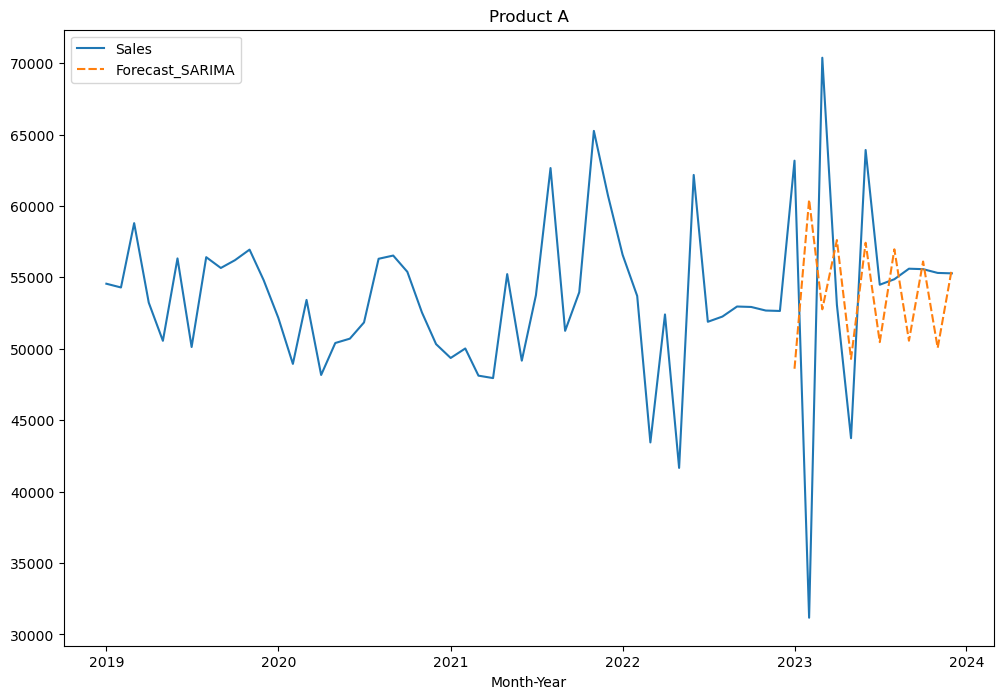

In [99]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_SARIMA']])
plt.title('Product A')

In [100]:
mae_sarima= mean_absolute_error(test['Sales'],forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test['Sales'],forecast_test_sarima)
mse_sarima=mean_squared_error(test['Sales'], forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test['Sales'],forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 7941.183
MAPE - SARIMA: 0.171
MSE - SARIMA: 128916991.717
RMSE - SARIMA: 11354.162


# AUTO-ARIMA

In [102]:
import pmdarima as pm

In [103]:
auto_arima= pm.auto_arima(train['Sales'], start_p=0,  start_q=0, max_p=6,max_q=2,
                          start_P=0, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12, exogenous=train[['Market Size','Marketing Expense']])
auto_arima

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=944.915, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=946.894, Time=0.03 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=948.774, Time=0.09 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=946.915, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=948.894, Time=0.22 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=950.774, Time=0.23 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=948.903, Time=0.41 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=950.777, Time=0.80 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=952.775, Time=0.25 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=950.858, Time=2.33 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=954.368, Time=2.71 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=954.758, Time=1.59 sec
 ARIMA(0,0,0)(4,0,0)[12] intercept   : AIC=952.770, Time=6.15 sec
 ARIMA(0,0,0)(4,0,1)[12] intercept   : AIC=954.762, Time=4.25 sec
 ARIMA(0,0,0)(5,0,0)[12] intercept   : AIC=954.763, Time=12.70 sec
 ARIMA(0,

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [104]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                        SARIMAX   Log Likelihood                -470.458
Date:                Tue, 14 May 2024   AIC                            944.915
Time:                        20:12:19   BIC                            948.658
Sample:                    01-01-2019   HQIC                           946.329
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.328e+04    634.460     83.976      0.000     5.2e+04    5.45e+04
sigma2      1.909e+07   3.18e+06      5.998      0.000    1.28e+07    2.53e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.40   Prob(JB):                         0.30
Heteroskedasticity (H):               3.64   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

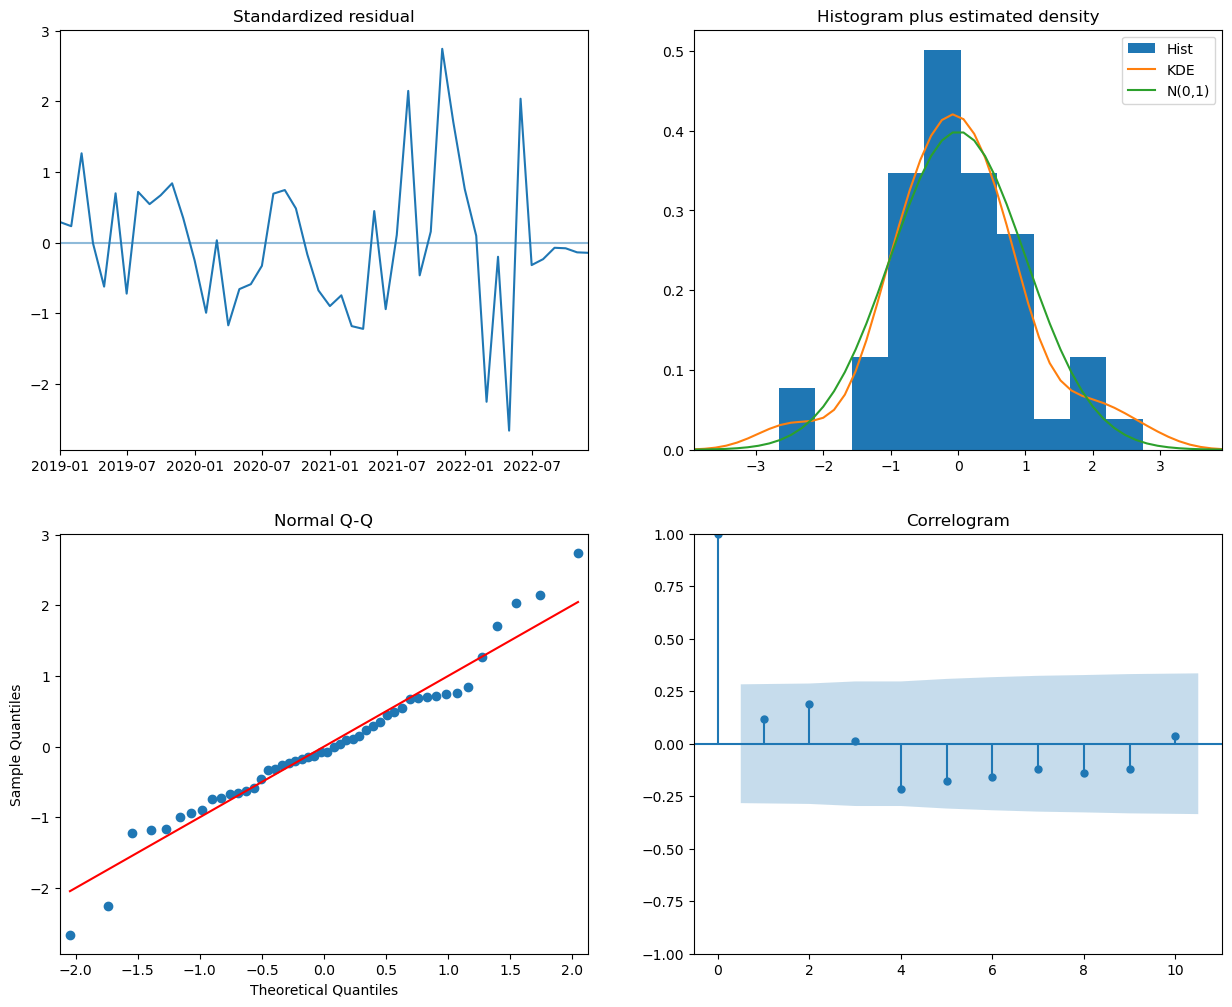

In [105]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [106]:
forecast_test_auto= auto_arima.predict(n_periods=len(test), exogenous=test[['Market Size','Marketing Expense']])
sales_a['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product A')

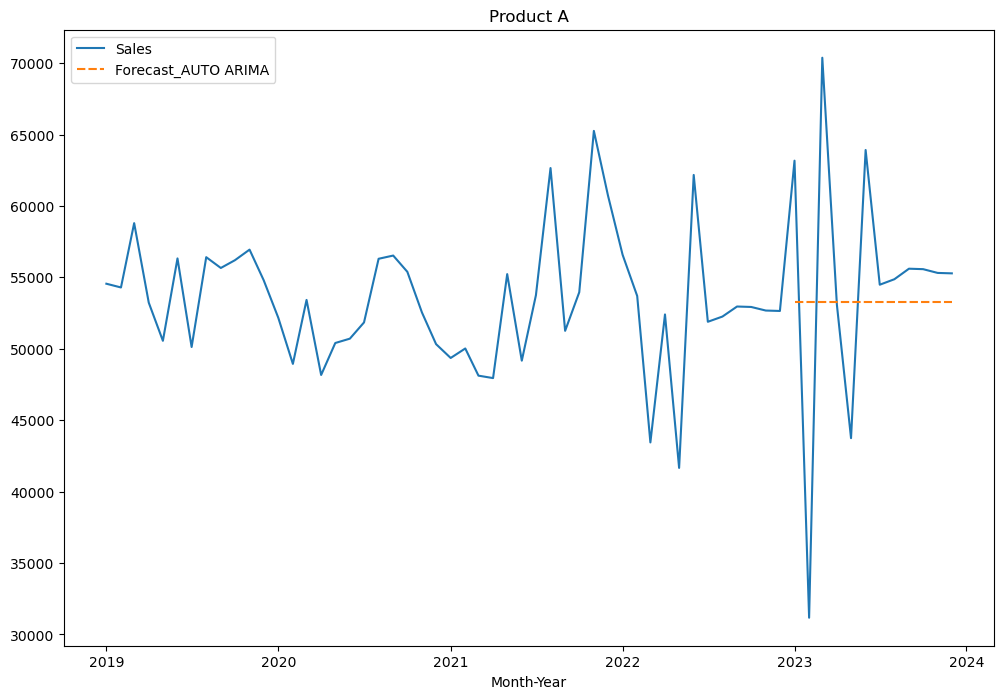

In [107]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product A')

In [108]:
mae_auto_arima= mean_absolute_error(test['Sales'],forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test['Sales'],forecast_test_auto)
mse_auto_arima=mean_squared_error(test['Sales'],forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test['Sales'],forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 6744.593749999988
MAPE - AUTO ARIMA: 0.1420423384192015
MSE - AUTO ARIMA: 92184635.2539062
RMSE - AUTO ARIMA: 9601.283000407091


In [110]:
sales_a.tail(12)

,Sales,Market Size,Marketing Expense,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,,,
2023-01-01,63171,2955148,236101,53362.624555,48600.976295,53279.3125
2023-02-01,31168,10151977,811092,62088.884894,60441.995878,53279.3125
2023-03-01,70380,5636182,450302,57306.192795,52764.946521,53279.3125
2023-04-01,53078,9134343,729788,61027.503322,57611.036382,53279.3125
2023-05-01,43741,3980872,318051,55235.081346,49290.641606,53279.3125
2023-06-01,63919,9490711,758260,60666.049133,57422.388767,53279.3125
2023-07-01,54485,5339196,426575,56113.490951,50466.032313,53279.3125
2023-08-01,54869,9714819,776165,60645.639405,56964.024900,53279.3125
2023-09-01,55607,5938316,474441,56685.961614,50566.710348,53279.3125


In [111]:
sales_a.mean()

Sales                  5.356653e+04
Market Size            6.014570e+06
Marketing Expense      3.312196e+05
Forecast_ARIMA         5.852346e+04
Forecast_SARIMA        5.382455e+04
Forecast_AUTO ARIMA    5.327931e+04
dtype: float64

In [112]:
sales_a.tail(12)

,Sales,Market Size,Marketing Expense,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,,,
2023-01-01,63171,2955148,236101,53362.624555,48600.976295,53279.3125
2023-02-01,31168,10151977,811092,62088.884894,60441.995878,53279.3125
2023-03-01,70380,5636182,450302,57306.192795,52764.946521,53279.3125
2023-04-01,53078,9134343,729788,61027.503322,57611.036382,53279.3125
2023-05-01,43741,3980872,318051,55235.081346,49290.641606,53279.3125
2023-06-01,63919,9490711,758260,60666.049133,57422.388767,53279.3125
2023-07-01,54485,5339196,426575,56113.490951,50466.032313,53279.3125
2023-08-01,54869,9714819,776165,60645.639405,56964.024900,53279.3125
2023-09-01,55607,5938316,474441,56685.961614,50566.710348,53279.3125


In [113]:
data = {
    'model': ['ARIMAX', 'AUTO ARIMAX', 'SEASONAL ARIMAX'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMAX,8163.897106,0.182120,1.276950e+08,11300.223140
AUTO ARIMAX,6744.593750,0.142042,9.218464e+07,9601.283000
SEASONAL ARIMAX,7941.182922,0.170578,1.289170e+08,11354.161868


# TESTING

In [43]:
auto_arima_1= pm.auto_arima(train['Sales'], start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12, exogenous=train[['Market Size','Marketing Expense']])
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1374.393, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1376.384, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1377.119, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1376.387, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1378.263, Time=0.10 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1378.671, Time=0.23 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1377.144, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1378.530, Time=0.22 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1380.459, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1350.206, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1350.297, Time=0.10 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1351.489, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1352.086, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIM

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [44]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(3, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -660.560
Date:                            Wed, 08 May 2024   AIC                           1335.120
Time:                                    18:26:04   BIC                           1348.071
Sample:                                01-01-2019   HQIC                          1339.994
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.218e+04   2.76e+04      1.529      0.126   -1.19e+04    9.63e+04
ar.L1         -0.7728      0.212     -3.647      0.000      -1.188      -0.358
ar.L2         -0.4947      0.256     -1.934      0.053      -0.996       0.007
ar.L3         -0.3294      0.161     -2.051      0.040      -0.644      -0.015
ma.L1         -0.6157      0.175     -3.516      0.000      -0.959      -0.272
ma.S.L12       0.3138      0.234      1.340      0.180      -0.145       0.773
sigma2       8.38e+10      0.007   1.17e+13      0.000    8.38e+10    8.38e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.40   Prob(JB):                         0.64
Heteroskedasticity (H):               1.03   Skew:                            -0.17
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.21e+29. Standard errors may be unstable.
"""

In [49]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test), exogenous=test[['Market Size','Marketing Expense']])
sales_b['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product B')

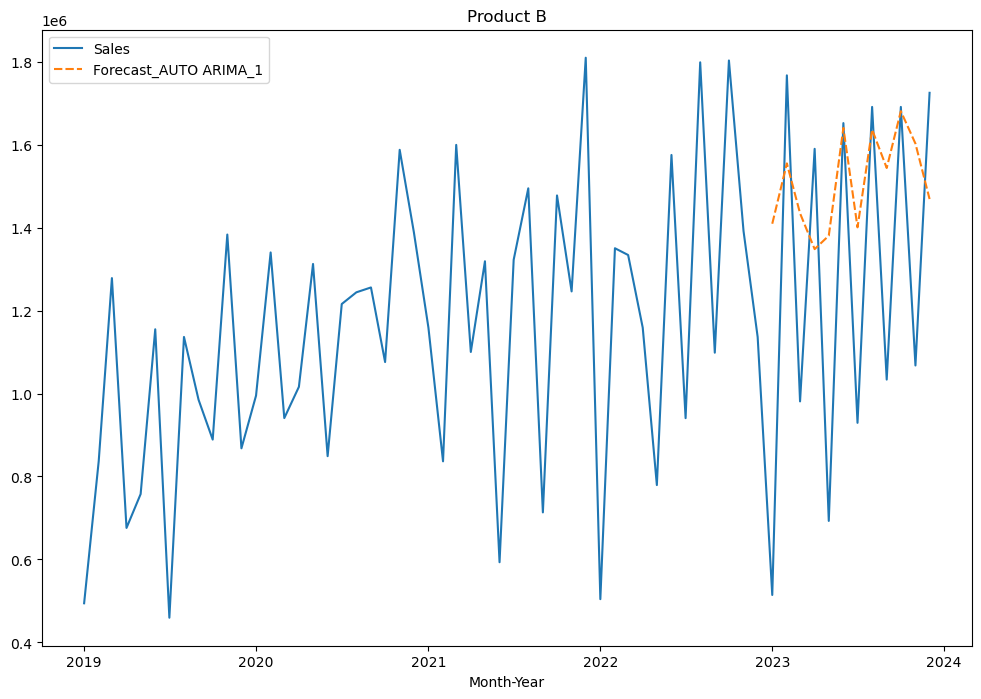

In [50]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product B')

In [51]:
mae_auto_arima_1= mean_absolute_error(test['Sales'],forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test['Sales'],forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test['Sales'],forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test['Sales'],forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 361595.78675793833
MAPE - AUTO ARIMA: 0.4301972486948735
MSE - AUTO ARIMA: 201684310197.0093
RMSE - AUTO ARIMA: 449092.7634654218
